# import

In [1]:
import os
import math
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import copy
from qutip import *
from qutip.fileio import *
from qutip.interpolate import *
import qutip.ipynbtools as qpipy
from qutip.qip.operations import cphase as CPhase
from qutip.qip.operations import rz
from scipy.fft import fft, fftfreq
from scipy.special import erf
from scipy.interpolate import interp1d
from scipy import signal
from scipy.integrate import odeint
from scipy import linalg
from scipy.optimize import minimize , minimize_scalar
import scipy.constants as cn
import random
import cmath
import itertools
from cycler import cycler
from pynverse import inversefunc
from IPython.display import display, Math
import warnings

d:\anaconda\anaconda\lib\site-packages\qutip\__init__.py:93: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.15.
  .format(_cy_require, _Cython.__version__)


In [2]:
# 可交互图像
%matplotlib notebook

In [3]:
%matplotlib inline

# 初始化

## 参数

In [4]:
device_paras={'w': np.array([5, 4.5]), \
              'alpha': np.array([-220,-220]), \
              'g': 100}

## 希尔伯特空间

In [5]:
Nstates = 3
#升降算符
a = destroy(Nstates)
a_dagger = create(Nstates)  
I = qeye(Nstates)
I2= tensor(I,I)
a1 = tensor(a,I)
a1d = a1.dag()  
a2 = tensor(I,a)
a2d = a2.dag()
#单比特初始裸态
ground = basis(Nstates,0)
excited = basis(Nstates,1)
leakage = basis(Nstates,2)
sx1 = a1 + a1d
sy1 = 1j*(a1d - a1)
sz1 = I2 - 2*a1d*a1
sx2 = a2 + a2d
sy2 = 1j*(a2d - a2)
sz2 = I2 - 2*a2d*a2


## 系统哈密顿量

In [6]:
def Hamiltonian(device_paras):
    w1=device_paras['w'][0]*2.0*np.pi
    w2=device_paras['w'][1]*2.0*np.pi
    alpha1=device_paras['alpha'][0]*10**(-3)*2.0*np.pi
    alpha2=device_paras['alpha'][1]*10**(-3)*2.0*np.pi

    g=device_paras['g']*10**(-3)*2.0*np.pi

    H0 = w1*a1d*a1+w2*a2d*a2 +\
          alpha1/2.0* a1d * a1d * a1 * a1+alpha2/2.0* a2d * a2d * a2 * a2
    HI = -g*(a1-a1d)*(a2 - a2d)
    H = H0+HI
    return H0 ,H 
    

## 本征态

In [20]:
#定义基本的能级顺序
energy_info = {'dim':[3]*2, 'exci_num': 4, 'bas_list':[], 'bas_name_list':[]}

for bas in state_number_enumerate(energy_info['dim'], excitations=energy_info['exci_num']):
    energy_info['bas_list'].append(state_number_qobj(energy_info['dim'], bas))
    energy_info['bas_name_list'].append(''.join(map(str,bas)))
energy_info['bas_num'] = len(energy_info['bas_list'])

print(energy_info['bas_name_list'])

['00', '01', '02', '10', '11', '12', '20', '21', '22']


In [8]:
def eigensolve(H0,H):
    # 使用eigenstates()函数计算哈密顿量的本征态和本征矢
    ei_states = H.eigenstates() # 得到dressed states的能级变化
    ei_energy = ei_states[0]
    ei_vector = ei_states[1]
    
    ei_states0 = H0.eigenstates() # 得到bare states的能级变化
    ei_energy0 = ei_states0[0]
    ei_vector0 = ei_states0[1]
    
    states_order = ei_vector.copy()
    states0_order = ei_vector.copy()
    energy_order = ei_energy.copy()
    energy0_order = ei_energy.copy()
    for n,vector in enumerate(ei_vector0):
        try:
            index = energy_info['bas_list'].index(vector)
            states_order[index] = ei_vector[n]
            states0_order[index] = ei_vector0[n]
            energy_order[index] = ei_energy[n]
            energy0_order[index] = ei_energy0[n]
            
        except:
            pass
    
    return states_order, states0_order , energy_order, energy0_order

## 计算ZZ耦合

In [26]:
def ZZcoupling(device_paras):
    H0,H = Hamiltonian(device_paras)
    states, states0, energy, energy0 =eigensolve(H0,H)

    zeta= energy[state_number_index(energy_info['dim'], [1, 1])] - energy[state_number_index(energy_info['dim'], [0, 1])]-\
    (energy[state_number_index(energy_info['dim'], [1, 0])] - energy[state_number_index(energy_info['dim'], [0, 0])])
    return abs(zeta / (2 * np.pi * 10 ** (-3)))

In [27]:
ZZcoupling(device_paras)

33.86348484775112

## 计算哈密顿量本征态

In [11]:
#系统哈密顿量
w1, w2 = device_paras['w'][0], device_paras['w'][1]
alpha1, alpha2 = device_paras['alpha'][0], device_paras['alpha'][1]
g = device_paras['g']
H0=2 * np.pi * (w1 * a1.dag() * a1 + w2 * a2.dag() * a2 + alpha1 / 2.0 * a1.dag() * a1.dag() * a1 * a1+alpha2 / 2.0* a2.dag() * a2.dag() * a2 * a2)
H12 = 2 * np.pi * (-g * (a1 - a1.dag()) * (a2 - a2.dag()))
H = H0+H12
#求本征能量和修饰态
energy, states=H.eigenstates()
#求相似变换矩阵
S=states[0]
for i in range(1, 9):
    S=np.c_[S,states[i]]
for i in S:
    outputN = ''
    for j in i:
        outputN = outputN + str(np.real(j))[:8] + ' ' + ' ' * (8 - len(str(np.real(j))[:8]))
    print(outputN)

0.083709 0.0      -0.10756 -0.00118 0.0      0.0      0.916091 0.0      -0.37709 
0.0      0.255532 0.0      0.0      0.399215 0.659626 0.0      0.583286 0.0      
-0.19811 0.0      0.595221 -0.70389 0.0      0.0      0.197521 0.0      0.268302 
0.0      -0.25509 0.0      0.0      0.398348 -0.65918 0.0      0.584570 0.0      
0.438882 0.0      -0.30488 -0.00249 0.0      0.0      0.255714 0.0      0.805626 
0.0      0.659836 0.0      0.0      0.583244 -0.25624 0.0      -0.39846 0.0      
-0.19748 0.0      0.587116 0.710298 0.0      0.0      0.198605 0.0      0.268935 
0.0      -0.65897 0.0      0.0      0.584611 0.254371 0.0      -0.39909 0.0      
0.849780 0.0      0.443264 0.002375 0.0      0.0      -0.13010 0.0      -0.25388 


# 单比特门

## 驱动脉冲

In [12]:
def drive_pulseX1(t, args):  
    t_g = args['gate time']
    amp = args['q1 amp']
    w_d = args['q1 drive frequency']*2*np.pi
    alpha = device_paras['alpha'][0]*2*np.pi*10**(-3)
    detune = args['q1 detune']*2*np.pi*10**(-3)
    lambda1 = args['drag weight']
    phi = args['q1 phi']*2*np.pi*10**(-3)
    I=np.cos(phi)
    Q=np.sin(phi)
    X0=amp * (1-np.cos(2*np.pi*t/tg))/2 
    Y0=- amp * np.pi/tg * np.sin(2*np.pi*t/tg)/alpha*lambda1
    X = (X0* I +Y0* Q)*np.cos((w_d+detune) * t) 
    return X

def drive_pulseY1(t, args):  
    t_g = args['gate time']
    amp = args['q1 amp']
    w_d = args['q1 drive frequency']*2*np.pi
    alpha = device_paras['alpha'][0]*2*np.pi*10**(-3)
    detune = args['q1 detune']*2*np.pi*10**(-3)
    lambda1 = args['drag weight']
    phi = args['q1 phi']*2*np.pi*10**(-3)
    I=np.cos(phi)
    Q=np.sin(phi)
    X0=amp * (1-np.cos(2*np.pi*t/tg))/2 
    Y0=- amp * np.pi/tg * np.sin(2*np.pi*t/tg)/alpha*lambda1
    Y = (Y0* I -X0* Q)*np.cos((w_d+detune) * t) 
    return Y

## 单比特QPT

Text(0.5, 0.92, 'Rx')

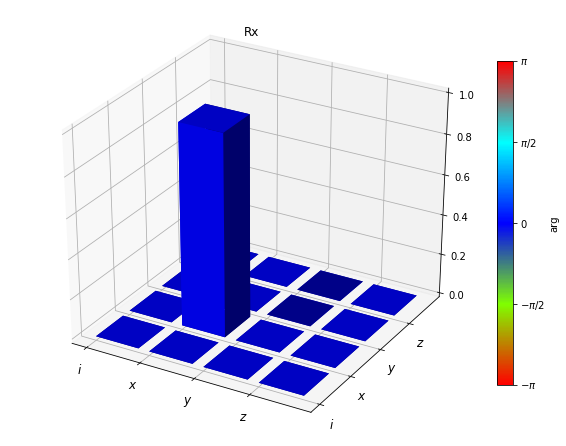

In [13]:
rho0 = fock_dm(3,0)
rho1 = fock_dm(3,1)
rho2 = ket2dm((basis(3,0)+basis(3,1))/np.sqrt(2))
rho3 = ket2dm((basis(3,0)+1j*basis(3,1))/np.sqrt(2))
rho_basis = [rho0, rho1, rho2, rho3]
rho_in = [tensor(rho,rho0) for rho in rho_basis]

op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]]
U_rho = spre(sigmax()) * spost(sigmax().dag())
# U_rho = spre(sigmax())
# U_rho = sprepost(sigmax(), sigmax().dag())
chi_ideal = qpt(U_rho, op_basis)

op_label = [["$i$", "$x$", "$y$", "$z$"] for i in range(1)]
name = 'Rx'
figsize = (8, 6)
fig, ax = qpt_plot_combined(chi_ideal, op_label, name, figsize=figsize)
ax.set_title(name)

In [14]:
def qpt1(U):
    rho_out=[(U * rho_in[i] * U.dag()).ptrace(0)[[0,1],:][:,[0,1]] for i in range(len(rho_in))]
    rho_basis_mat = np.hstack([mat2vec(rho.full()) for rho in rho_basis])
    rho_out_mat = np.hstack([mat2vec(rho) for rho in rho_out])
    Gamma = linalg.solve(rho_basis_mat.T, rho_out_mat.T)
    Gamma = Gamma.T
    vecGamma = mat2vec(Gamma)
    
    op_basis = [qeye(2), sigmax(), sigmay(), sigmaz()]
    EE_ops = [sprepost(E1, E2.dag()) for E1 in op_basis for E2 in op_basis]
    Beta = np.hstack([mat2vec(EE.full()) for EE in EE_ops])
    vecChi = linalg.solve(Beta, vecGamma)
    Chi = vec2mat(vecChi)
    return Chi

## 保真度计算

In [15]:
def Fidelity_X(U):
    
    f = lambda phi :  1-abs(np.trace(np.dot((rz(phi)*U).dag(),(rz(phi)*U)))+(abs(np.trace(np.dot(sigmax().dag(),(rz(phi)*U))))** 2))/6
    res = minimize_scalar(f, method='brent')
    return res.fun

## 哈密顿量演化

In [16]:
tg = 30
t_list = np.linspace(0,tg,300) 
def Evolution_q1(pulse_paras,H,states,n):

    H_x1 = [sx1 , drive_pulseX1]
    H_y1 = [sy1 , drive_pulseY1]
    Ht = [H, H_x1 ,H_y1]


    args1['q1 amp'] = pulse_paras[1]
    args1['q1 detune']=pulse_paras[0]
    args1['q1 phi']=-pulse_paras[0]*tg/2

    U_full=propagator(Ht,t_list,args = args1)[-1]
    U=np.zeros([2,2],dtype='complex128')
    for i in range(2):
        for j in range(2):
            U[i][j]=(states[state_number_index(energy_info['dim'], [i, n])].dag() * \
                U_full*states[state_number_index(energy_info['dim'], [j, n])]).full()[0][0]
    error = Fidelity_X(Qobj(U))

    return error 

## 并行单比特门计算

In [17]:
def par_X1(device_paras):
    global args1
    args1 = {}  
    args1['gate time'] = tg
    args1['q1 drive frequency'] = device_paras['w'][0]
    args1['drag weight']=0.5
    
    H0,H = Hamiltonian(device_paras)
    states, states0, energy, energy0 =eigensolve(H0,H)

    #校准Q1，校准时Q2置0
    detune_0 = (energy[state_number_index(energy_info['dim'], [1, 0])] - \
            energy[state_number_index(energy_info['dim'], [0, 0])] - \
            energy0[state_number_index(energy_info['dim'], [1, 0])] + \
            energy0[state_number_index(energy_info['dim'], [0, 0])]) / (2*np.pi*10**(-3))
    x0 = [detune_0,0.21]
    bounds = ((x0[0]-10,x0[0]+10),(x0[1]-0.07,x0[1]+0.07) )
    start = time.time();count=0;error_list = [];
    result1 = minimize(Evolution_q1, x0 ,args=(H,states,0,),bounds=bounds, method='SLSQP',options={'ftol': 1e-06})
    
    #Q2置1,演化Q1
    error = Evolution_q1(result1.x, H, states, 1)

    return error


In [18]:
par_X1(device_paras)

0.5336971545614064

In [ ]:
parameter=[]
w2_list=np.linspace(3, 7, 40)
g_list=np.linspace(0., 200, 40)
error_Q2_1 = []
i = 0
for g in g_list:
    for w2 in w2_list:
        device_paras['w']=np.array([5, w2])
        device_paras['g']=g
        parameter.append(device_paras)
        error_Q2_1.append(par_X1(device_paras))
        i += 1
        if not i % 16:
            print(str(i / 16) + '%')

# error_Q2_1 = parallel_map(par_X1, parameter, progress_bar=True, num_cpus=24)     

In [ ]:
##计算ZZ耦合
zeta_list = parallel_map(ZZcoupling, parameter, progress_bar=True,num_cpus=2) 

<IPython.core.display.Javascript object>


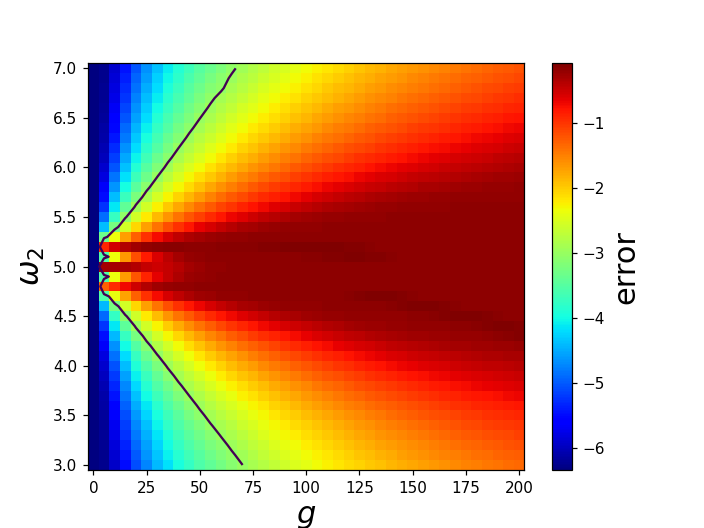

Text(0, 0.5, '$\\omega_2$')

In [ ]:
error_list = [math.log(e,10) for e in error_Q2_1[1]]
error_arr = np.array(error_list).reshape(len(g_list),len(w2_list))

#plot
xx,yy = np.meshgrid(g_list,w2_list)

font2 = {'family' : 'Times New Roman','weight' : 'normal','size' : 20}
fig, ax = plt.subplots()
c = ax.pcolormesh(xx,yy,error_arr.T,cmap='jet')
cb=plt.colorbar(c, ax=ax)
plt.contour(xx,yy,error_arr.T,[-3])

cb.set_label('error',fontdict=font2) 

plt.xlabel('$g$',font2)
plt.ylabel('$\omega_2$',font2)



In [ ]:
path='图片/ZZ耦合搜索结果/单比特门保真度'
plt.savefig(path+'.png', dpi=500, bbox_inches='tight')

<IPython.core.display.Javascript object>


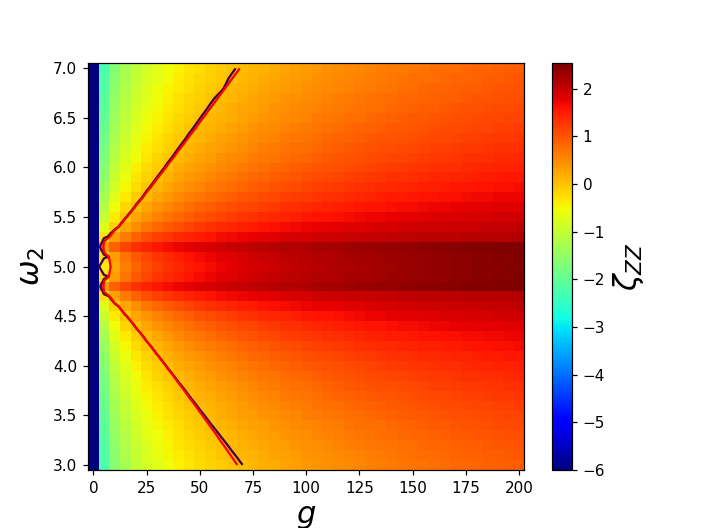

Text(0, 0.5, '$\\omega_2$')

In [ ]:
zeta_list_log = [math.log(abs(e+0.000001),10) for e in zeta_list]
zeta_arr = np.array(zeta_list_log).reshape(len(g_list),len(w2_list))

#plot
xx,yy = np.meshgrid(g_list,w2_list)

font2 = {'family' : 'Times New Roman','weight' : 'normal','size' : 20}
fig, ax = plt.subplots()
c = ax.pcolormesh(xx,yy,zeta_arr.T,cmap='jet')
cb=plt.colorbar(c, ax=ax)
plt.contour(xx,yy,error_arr.T,[-3])
plt.contour(xx,yy,zeta_arr.T,[0.03],cmap='hsv')
cb.set_label('$\zeta_{ZZ}$',fontdict=font2) 

plt.xlabel('$g$',font2)
plt.ylabel('$\omega_2$',font2)

In [ ]:
path='图片/ZZ耦合搜索结果/单比特门阈值'
plt.savefig(path+'.png', dpi=500, bbox_inches='tight')

##  脉冲校准

In [ ]:
def _EPGback(argi):
    global count

    if count%1 == 0:
        end=time.time()
        print('iter:{:d}  error:{:f}  {}  {:2f}'.format(count, error_list[-1] ,argi,end-start)) 
    count += 1

In [4]:
tg = 30
t_list = np.linspace(0,tg,300) 
args1 = {}  
args1['gate time'] = tg
args1['q1 drive frequency'] = device_paras['w'][0]
args1['drag weight']=0.5

H0,H = Hamiltonian(device_paras)
states, states0, energy, energy0 =eigensolve(H0,H)


#使用优化算法优化脉冲参数
detune_0=(energy[state_number_index(energy_info['dim'], [1, 0])] - energy[state_number_index(energy_info['dim'], [0, 0])] - \
        energy0[state_number_index(energy_info['dim'], [1, 0])] + energy0[state_number_index(energy_info['dim'], [0, 0])])/(2*np.pi*10**(-3))
x0 = [detune_0,0.21]
bounds = ((x0[0]-10,x0[0]+10),(x0[1]-0.07,x0[1]+0.07) )
start = time.time();count=0;error_list = [];
nm_result = minimize(Evolution_q1, x0 ,args=(H,states,0),bounds=bounds, method='SLSQP')


NameError: name 'device_paras' is not defined

In [ ]:
nm_result.x

0.21414194354325766

## 脉冲校准

In [23]:
tg = 30
t_list = np.linspace(0,tg,500)  
amp_all=[i for i in np.linspace(0.17,0.23,40) ]
drag_all=np.linspace(0,1.5,20)
detune_all=np.linspace(-20,-5,20)
#含驱动哈密顿量
H_x1 = [sx1 , drive_pulseX1]
H_y1 = [sy1 , drive_pulseY1]
Ht = [H, H_x1 ,H_y1 ]



def find_bestamp(parameter):
    detune=parameter[0]
    drag=parameter[1]
    amp=parameter[2]
    
    args1 = {}  
    args1['gate time'] = tg
    args1['q1 amp'] = amp
    args1['q1 drive frequency'] = w1
    args1['drag weight']=drag
    args1['q1 detune']=detune
    args1['q1 phi']=-detune*tg/2

    U=propagator(Ht,t_list,args = args1)[-1]
#     U_d=U.transform(S)

#     chi = qpt1(U_d)
    
    
    
#     F=abs(np.trace(np.dot(chi_ideal,chi)))
    
    
    
    
    U_t=states[0].dag()*U*states[0]*fock_dm(2,0)+states[0].dag()*U*states[1]*destroy(2)+\
          states[1].dag()*U*states[0]*create(2)+states[1].dag()*U*states[1]*fock_dm(2,1)

    
    F=abs(np.trace(np.dot(U_t.dag(),U_t))+(abs(np.trace(np.dot(sigmax().dag(),U_t))))** 2)/6
    return 1-F

parameter=[]
for detune in detune_all:
    for amp in amp_all:
        parameter.append([detune,0.5,amp])
        
        
error = parallel_map(find_bestamp, parameter, progress_bar=True,num_cpus=18)

: 

<IPython.core.display.Javascript object>


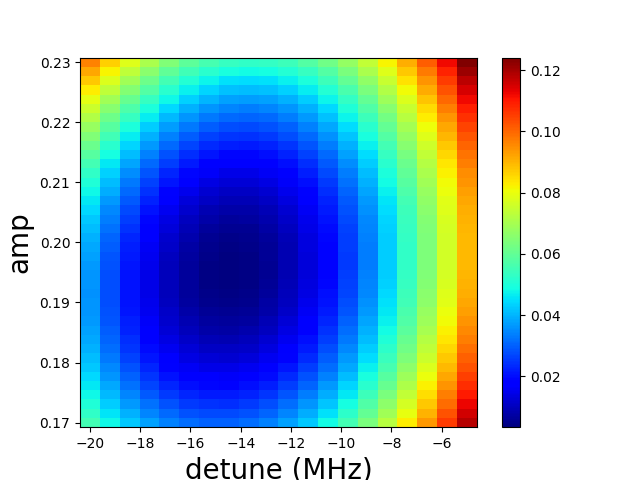

Text(0, 0.5, 'amp')

In [ ]:
error_arr = np.array(error).reshape(len(detune_all),len(amp_all))

#plot
xx,yy = np.meshgrid(detune_all,amp_all)

fig, ax = plt.subplots()
c = ax.pcolormesh(xx,yy,error_arr.T,cmap='jet')

fig.colorbar(c, ax=ax)

font2 = {'family' : 'Times New Roman','weight' : 'normal','size' : 20}
plt.xlabel('detune (MHz)',font2)
plt.ylabel('amp',font2)

In [ ]:
detune=parameter[0][0]*10**(-3)*2.0*np.pi
drag=parameter[0][1]
amp=parameter[0][2]

args1 = {}  
args1['gate time'] = tg
args1['q1 amp'] = amp
args1['q1 drive frequency'] = w1
args1['drag weight']=drag
args1['q1 detune']=detune
args1['q1 phi']=-detune*tg/2

U=propagator(Ht,t_list,args = args1)[-1]
U_t=states[0].dag()*U*states[0]*fock_dm(2,0)+states[0].dag()*U*states[1]*destroy(2)+\
          states[1].dag()*U*states[0]*create(2)+states[1].dag()*U*states[1]*fock_dm(2,1)

F=abs(np.trace(np.dot(U_t.dag(),U_t))+(abs(np.trace(np.dot(sigmax().dag(),U_t))))** 2)/6


In [ ]:
min(error)

0.003425391889855689